## Airlines lose tens of billions of dollars annually (at over $30 billion in the U.S. and up to $60-$67 billion globally) due to delays. Can we predict which flights are at risk 24 hours in advance so they can proactively rebook passengers?

In [2]:
import pandas as pd # you could use pandas for the same operations if it is more familiar.

df = pd.read_csv(r'C:\Users\User\Documents\UDE\Flights_preds\data\Airline_Delay_Cause.csv')
df.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",89.0,13.0,2.25,1.60,...,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",62.0,10.0,1.97,0.04,...,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,10.0,2.73,1.18,...,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",66.0,12.0,3.69,2.27,...,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",92.0,22.0,7.76,0.00,...,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


In [3]:
df.shape

(171666, 21)

In [4]:
df.columns

Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
       'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')

#### Some columns have unclear meanings so I will briefly explain each:
* arr_flights: Total arriving flights
* arr_del15: Arriving flights delayed 15+ minutes
* carrier_ct / weather_ct / nas_ct ... : Flights delayed due to airline carrier / weather / NAS issues.
* arr_cancelled / arr_diverted: Cancelled arriving flights / diverted arriving flights
* carrier_delay / weather_delay / nas_delay ... : Delay minutes due to carrier / weather / NAS.

In [5]:
df.describe()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,171666.000000,171666.000000,171426.000000,171223.000000,171426.000000,171426.000000,171426.000000,171426.000000,171426.000000,171426.000000,171426.000000,171426.00000,171426.000000,171426.000000,171426.000000,171426.000000,171426.000000
mean,2018.551361,6.493633,362.528467,66.434387,20.796615,2.250347,19.381147,0.157096,23.770554,7.530497,0.863387,4239.48733,1437.185124,222.563497,920.651704,7.382725,1651.700063
std,2.890006,3.440908,992.894662,179.540694,50.315176,7.314252,61.675244,0.717405,72.393477,43.654880,3.772853,12618.56605,4215.677812,821.086511,3423.509335,41.779985,5221.878385
min,2013.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,4.000000,50.000000,6.000000,2.160000,0.000000,1.000000,0.000000,1.230000,0.000000,0.000000,335.00000,110.000000,0.000000,34.000000,0.000000,65.000000
50%,2019.000000,7.000000,100.000000,17.000000,6.400000,0.400000,3.910000,0.000000,5.000000,1.000000,0.000000,1018.00000,375.000000,18.000000,146.000000,0.000000,320.000000
75%,2021.000000,9.000000,250.000000,47.000000,17.260000,1.860000,11.710000,0.000000,15.260000,4.000000,1.000000,2884.00000,1109.000000,146.000000,477.000000,0.000000,1070.000000
max,2023.000000,12.000000,21977.000000,4176.000000,1293.910000,266.420000,1884.420000,58.690000,2069.070000,4951.000000,197.000000,438783.00000,196944.000000,31960.000000,112018.000000,3760.000000,227959.000000


In [6]:
print(f"""
      {df['airport_name'].nunique()} unique airport names, 
      {df['airport'].nunique()} unique airports, 
      {df['carrier'].nunique()} unique carriers,
      {df['carrier_name'].nunique()} unique carrier names
        """)   # Columns with a large number of unique values will need special encoding techniques.


      419 unique airport names, 
      395 unique airports, 
      21 unique carriers,
      23 unique carrier names
        


#### It seems that the true names of airports and carriers are more unique, for this reason they are better features for encoding than the IDs. We cannot afford to mistake one airport for another simply because their IDs are the same.

In [7]:
types = df.dtypes 
for col, dtype in zip(df.columns, types):  
    print(f"{col}: {dtype}")   # The pairs of type:column  must be accurate.

year: int64
month: int64
carrier: object
carrier_name: object
airport: object
airport_name: object
arr_flights: float64
arr_del15: float64
carrier_ct: float64
weather_ct: float64
nas_ct: float64
security_ct: float64
late_aircraft_ct: float64
arr_cancelled: float64
arr_diverted: float64
arr_delay: float64
carrier_delay: float64
weather_delay: float64
nas_delay: float64
security_delay: float64
late_aircraft_delay: float64


#### Carefully analyzing the results reveals a few things:

* Nulls exist across most columns, often at a count of 240 (Maybe the same empty columns are causing this issue?)
* There are massive outliers (e.g. max of weather_delay	is 31960 but the 75th percentile value is 146!)
* Some columns like airport name have got a high count of distinct values.

These will be dealt with in the **preprocessing stage**. For now, we can proceed with the exploration.

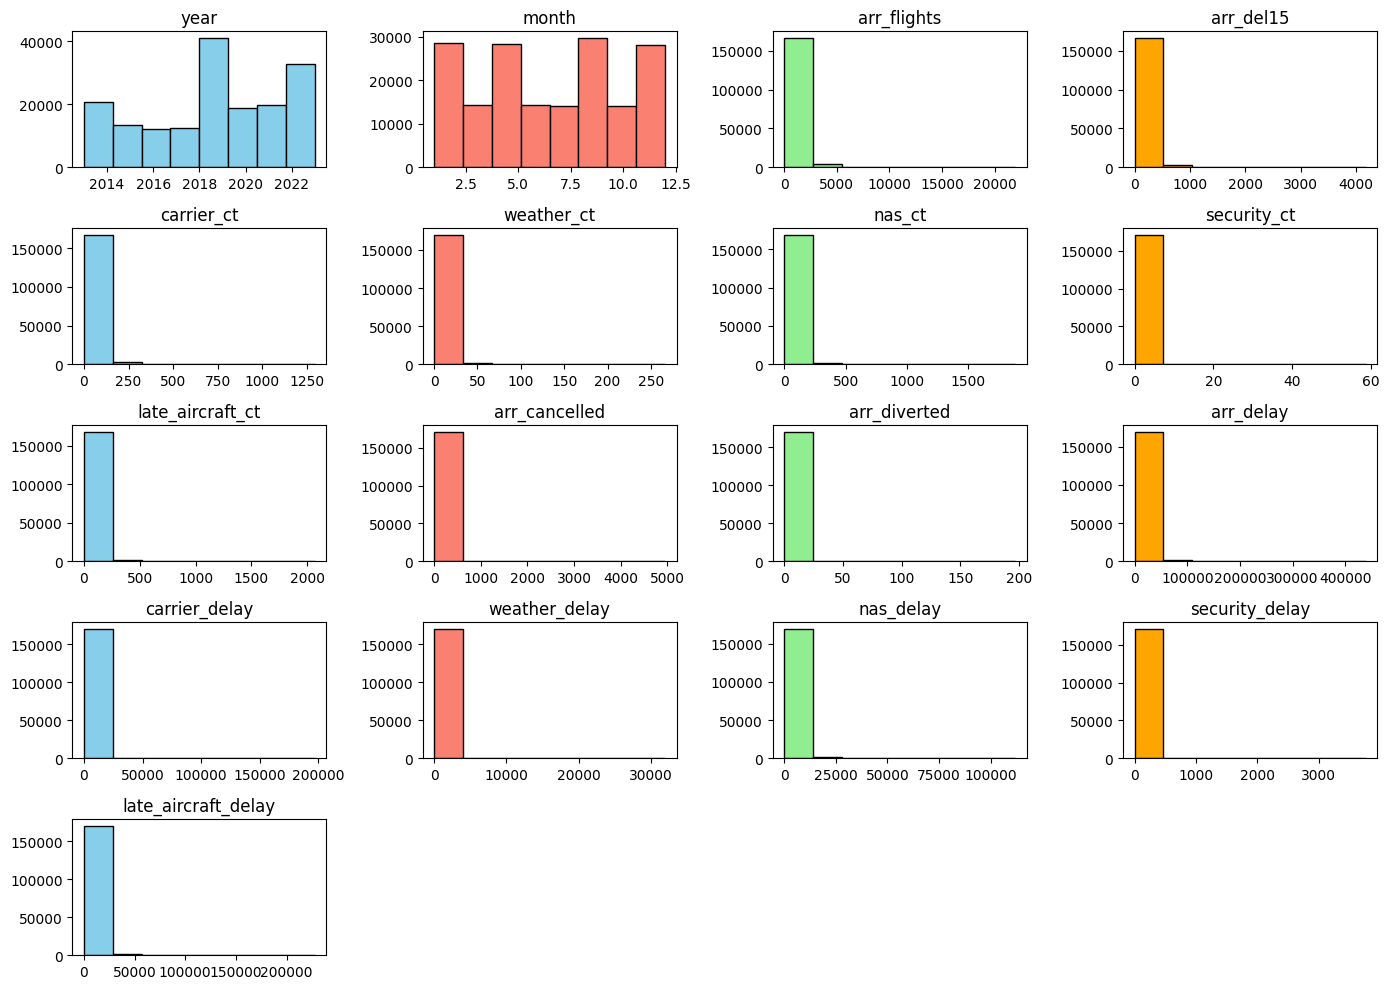

In [8]:
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(14, 10))
axes = axes.flatten()

colors = ["skyblue", "salmon", "lightgreen", "orange"]

for i, (ax, col) in enumerate(zip(axes, num_cols)):
    color = colors[i % 4]
    ax.hist(df[col].to_numpy(), bins=8, edgecolor="black", color=color)
    ax.set_title(col)

for ax in axes[len(num_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


#### --> Features are mostly positively skewed, making log transformations a good consideration. However it is important to note outliers are few, so log transformation **may or may not be all that necessary** say, if we remove outliers.

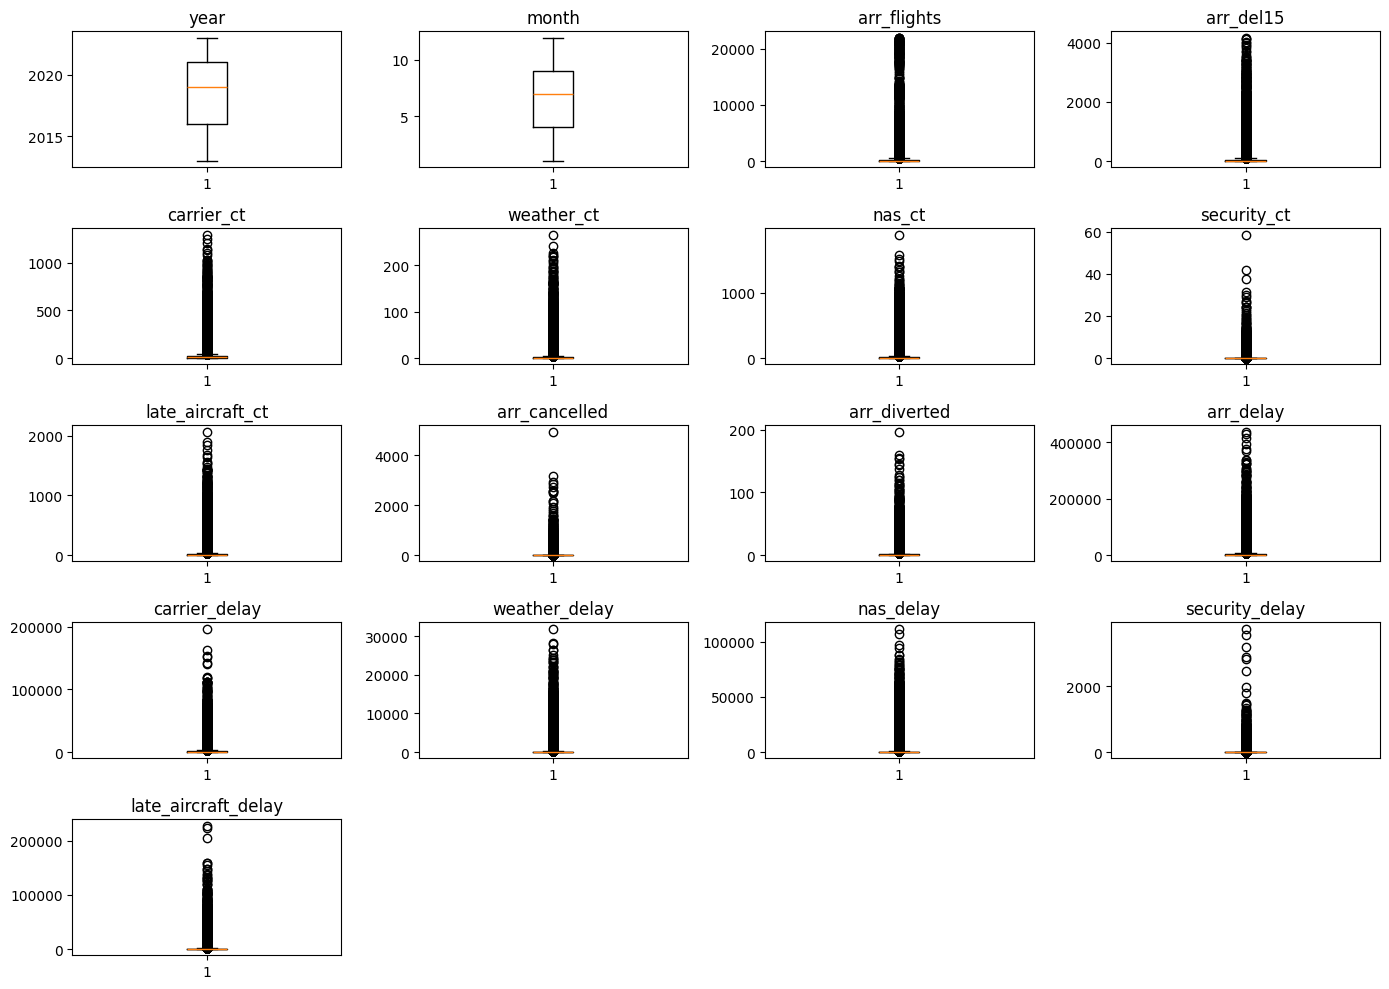

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 4, figsize=(14, 10))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    box_data = (  # we must drop nulls momentarily to plot boxplots
    df[col]
    .dropna(inplace=False)
    .to_numpy()
    )
    ax.boxplot(box_data, vert=True)
    ax.set_title(col)

for ax in axes[len(num_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


#### --> The frequency and distribution of these outliers suggest they are inherent to the data, not mistakes. Thus, removal would be unfair to the true structure of the data.

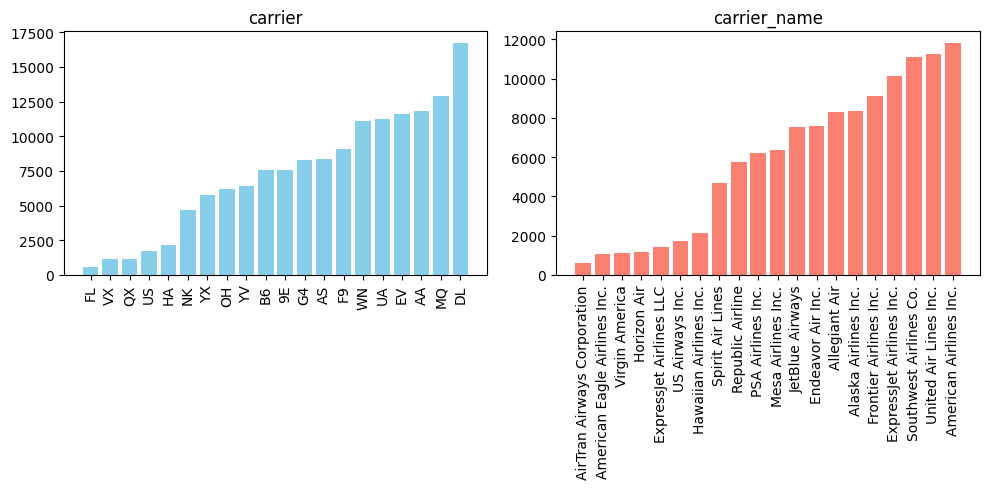

In [10]:
import matplotlib.pyplot as plt

low_cardinality_cat_cols = ['carrier','carrier_name']
colors = ["skyblue", "salmon"]
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes = axes.flatten()

for ax, col, color in zip(axes, low_cardinality_cat_cols , colors):
    counts = (
        df[col]
        .dropna()
        .value_counts()
        )
    counts_df = pd.DataFrame({col: counts.index, "count": counts.values}).sort_values(by = 'count').head(20)

    ax.bar(counts_df[col].to_list(), counts_df["count"].to_list(), color=color)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=90)

for ax in axes[len(low_cardinality_cat_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


#### --> Some carriers are more rare such as VX. This might not allow our model to learn the true impact of VX 

In [11]:
cts = df['airport_name'].value_counts()
air_name_counts = pd.DataFrame({col: cts.index, "count": cts.values}).sort_values(by = 'count')
print(air_name_counts['count'].max())
print(air_name_counts['count'].mean())
print(air_name_counts['count'].median())
print(air_name_counts['count'].min())
print(air_name_counts['count'].nunique())

1535
409.7040572792363
198.0
1
295


In [12]:
cts = df['airport_name'].value_counts()
air_counts = pd.DataFrame({col: cts.index, "count": cts.values}).sort_values(by = 'count')
print(air_counts['count'].max())
print(air_counts['count'].mean())
print(air_counts['count'].median())
print(air_counts['count'].min())
print(air_counts['count'].nunique())

1535
409.7040572792363
198.0
1
295


#### Now that we understand the shapes of our data, we can move on to understanding relationships.

* How have delays fluctuated throughout years and month?

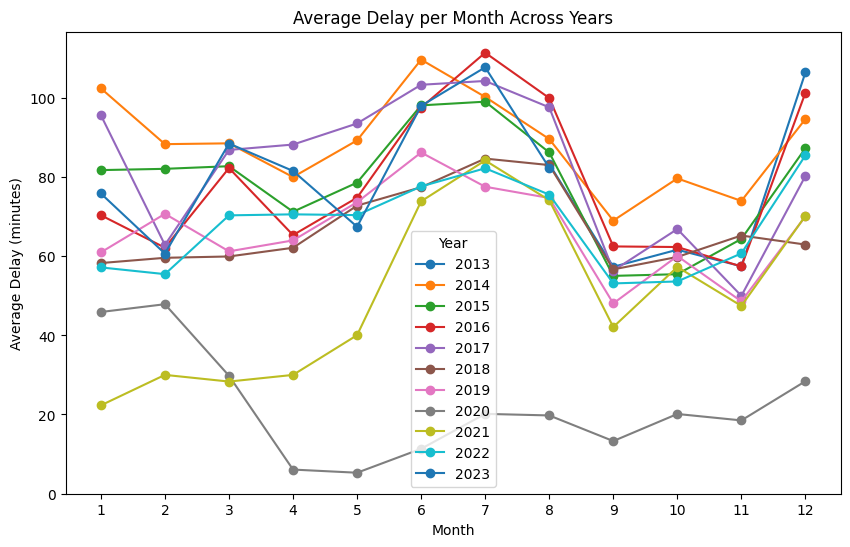

In [13]:
import matplotlib.pyplot as plt

agg = (
    df.groupby(["year", "month"], as_index=False)["arr_del15"]
      .mean()
      .sort_values(["year", "month"])
)

plt.figure(figsize=(10, 6))

for year, year_data in agg.groupby("year"):
    plt.plot(
        year_data["month"],
        year_data["arr_del15"],  
        marker="o",
        label=str(year)
    )

plt.title("Average Delay per Month Across Years")
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Month")
plt.xticks(range(1, 13))
plt.legend(title="Year")
plt.show()


#### --> The year 2020 shows a sharp reduction in both flight volume and delays, likely driven by the COVID-19 pandemic. Although a feature like `IsCovid` could help explain this period in hindsight, such events are inherently unpredictable in real-world forecasting. Including them as features risks leaking information that would not be available at inference time, and these effects are better treated as **distribution drift.**


* How frequent are delays across carriers, relative to that carrier's frequency in the dataset?

C:\Users\User\AppData\Local\Temp\ipykernel_16044\2215692819.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


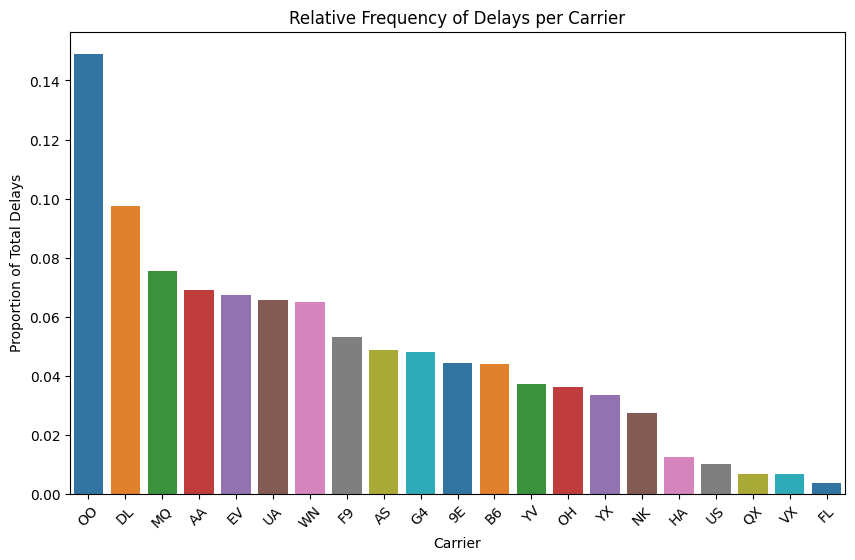

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

df_carrier = (
    df.groupby("carrier", as_index=False)["arr_del15"]
      .count()
      .rename(columns={"arr_del15": "num_delays"})
)

total_delays = df_carrier["num_delays"].sum()

df_carrier["rel_freq"] = df_carrier["num_delays"] / total_delays
df_carrier = df_carrier.sort_values("rel_freq", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_carrier,
    x="carrier",
    y="rel_freq",
    palette="tab10"
)

plt.title("Relative Frequency of Delays per Carrier")
plt.ylabel("Proportion of Total Delays")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.show()


#### --> Specific carriers have more delay than others.

* How frequent are delays across airports, relative to that airports' frequency in the dataset?

C:\Users\User\AppData\Local\Temp\ipykernel_16044\2970326508.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


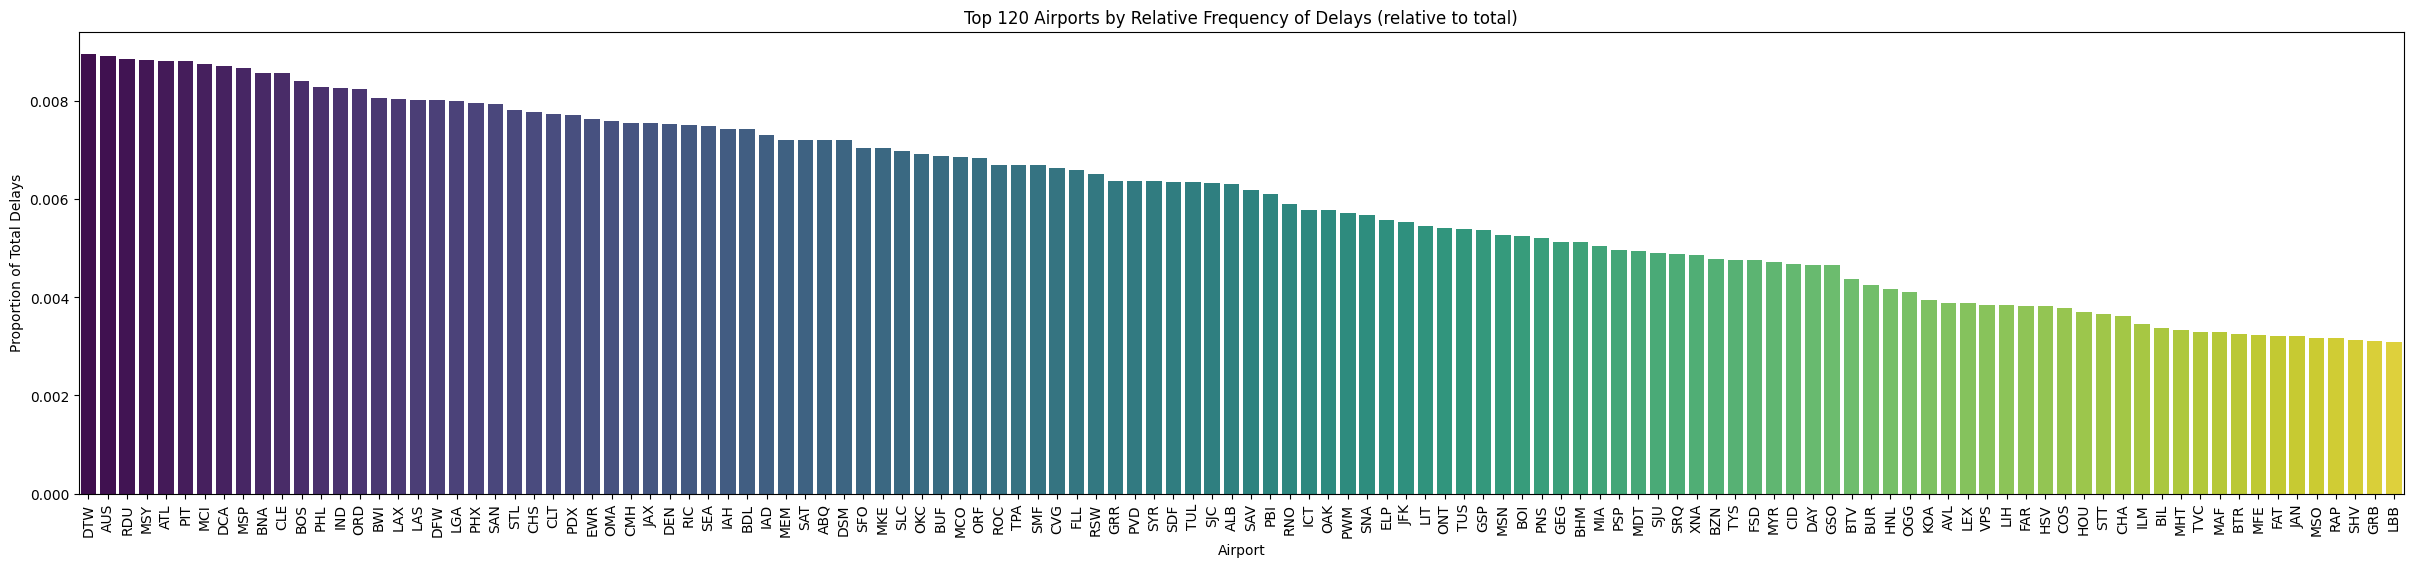

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

df_airport = (
    df.groupby("airport", as_index=False)["arr_del15"]
      .count()
      .rename(columns={"arr_del15": "num_delays"})
      .sort_values("num_delays", ascending=False)
      .head(120)
)

total_delays = df["arr_del15"].count()

df_airport["rel_freq"] = df_airport["num_delays"] / total_delays

plt.figure(figsize=(30, 6))
sns.barplot(
    data=df_airport,
    x="airport",
    y="rel_freq",
    palette="viridis"
)

plt.title("Top 120 Airports by Relative Frequency of Delays (relative to total)")
plt.ylabel("Proportion of Total Delays")
plt.xlabel("Airport")
plt.xticks(rotation=90)
plt.show()


#### --> Specific airports have more delay than others.

#### Our EDA reveals that this dataset is **rich in signal**, in other words, delay isn't the result of random noise.

#### To prepare our dataset for modelling, we must clean it first: 
* We noticed repetition of IDs in airports and carriers and decided to rely only on the true names.

In [16]:
df['carrier_name'].nunique()

23

In [17]:
encoded_carriers = pd.get_dummies(df['carrier_name'])
encoded_carriers.replace({True: 1, False: 0},inplace=True)
encoded_carriers

df.drop(columns=['carrier_name','carrier'], inplace=True)
df = df.join(encoded_carriers)
df.columns

C:\Users\User\AppData\Local\Temp\ipykernel_16044\504111644.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_carriers.replace({True: 1, False: 0},inplace=True)


Index(['year', 'month', 'airport', 'airport_name', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'AirTran Airways Corporation', 'Alaska Airlines Inc.', 'Allegiant Air',
       'American Airlines Inc.', 'American Eagle Airlines Inc.',
       'Delta Air Lines Inc.', 'Endeavor Air Inc.', 'Envoy Air',
       'ExpressJet Airlines Inc.', 'ExpressJet Airlines LLC',
       'Frontier Airlines Inc.', 'Hawaiian Airlines Inc.', 'Horizon Air',
       'JetBlue Airways', 'Mesa Airlines Inc.', 'PSA Airlines Inc.',
       'Republic Airline', 'SkyWest Airlines Inc.', 'Southwest Airlines Co.',
       'Spirit Air Lines', 'US Airways Inc.', 'United Air Lines Inc.',
       'Virgin America'],
      dtype='object')

* Airport names total 400+ unique names. We can either do **target encoding** or **encode the few** that are truly correlated with more delay. 
#### We earlier saw that the amount of delays fluctuates with different airports... but **different airports exist in different frequencies**, in reality this diversity could just be noise. I will examine the relationship between airport and delay frequency:

**Hypothesis:**
- H₀: Delay occurrence is independent of airport (any differences are due to random chance)
- H₁: Certain airports have significantly different delay rates

**Test:** Chi-square test of independence

In [18]:
df.drop(columns=['airport'], inplace=True) # no longer considered useful
df['is_delayed'] = df['arr_del15'].apply(lambda x: 1 if x == 1 else 0)

In [19]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['airport_name'], df['is_delayed'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")

Chi-square statistic: 3682.96
p-value: 0.0000


**Results:**
##### χ² = 3682.96, p < 0.05
--> We reject the null hypothesis at α = 0.05

In [20]:
from scipy.stats import chi2_contingency
import numpy as np

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print(f"Cramér's V: {cramers_v:.3f}")

Cramér's V: 0.146


--> Moderate Association.
**Now we test which airports drive this relationsip with one-way ANOVA and post-hoc analysis:**

In [ ]:
airport_stats = df.groupby('airport_name').agg({
    'arr_del15': 'sum',
    'arr_flights': 'sum',
}).reset_index()

airport_stats['delay_rate'] = airport_stats['arr_del15'] / airport_stats['arr_flights']
airport_stats['pct_of_total_flights'] = airport_stats['arr_flights'] / df['arr_flights'].sum()

overall_delay_rate = df['arr_del15'].sum() / df['arr_flights'].sum()

airport_stats['rate_difference'] = abs(airport_stats['delay_rate'] - overall_delay_rate)

airport_stats['importance'] = (
    airport_stats['rate_difference'] * 
    airport_stats['pct_of_total_flights']
)

airport_stats = airport_stats.sort_values('importance', ascending=False)

airport_stats.head(20)

,airport_name,arr_del15,arr_flights,delay_rate,pct_of_total_flights,rate_difference,importance
19,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",508434.0,3557460.0,0.142921,0.057243,0.040115,0.002296
269,"Newark, NJ: Newark Liberty International",288816.0,1166485.0,0.247595,0.018770,0.064559,0.001212
340,"San Francisco, CA: San Francisco International",345825.0,1501997.0,0.230243,0.024169,0.047208,0.001141
336,"Salt Lake City, UT: Salt Lake City International",147650.0,1103651.0,0.133783,0.017759,0.049253,0.000875
64,"Charlotte, NC: Charlotte Douglas International",253390.0,1671963.0,0.151552,0.026903,0.031483,0.000847
98,"Detroit, MI: Detroit Metro Wayne County",187536.0,1309481.0,0.143214,0.021071,0.039822,0.000839
241,"Minneapolis, MN: Minneapolis-St Paul Internati...",186133.0,1297444.0,0.143461,0.020877,0.039575,0.000826
268,"New York, NY: LaGuardia",274099.0,1229776.0,0.222885,0.019788,0.039849,0.000789
284,"Orlando, FL: Orlando International",271800.0,1297936.0,0.209409,0.020885,0.026374,0.000551
267,"New York, NY: John F. Kennedy International",226282.0,1064227.0,0.212626,0.017124,0.029590,0.000507


**Importance Score Analysis:**
After ranking all 419 airports by importance score (effect size × frequency), 
we observe a sharp drop-off after the top few airports:

AttributeError: module 'matplotlib.pyplot' has no attribute 'tight'

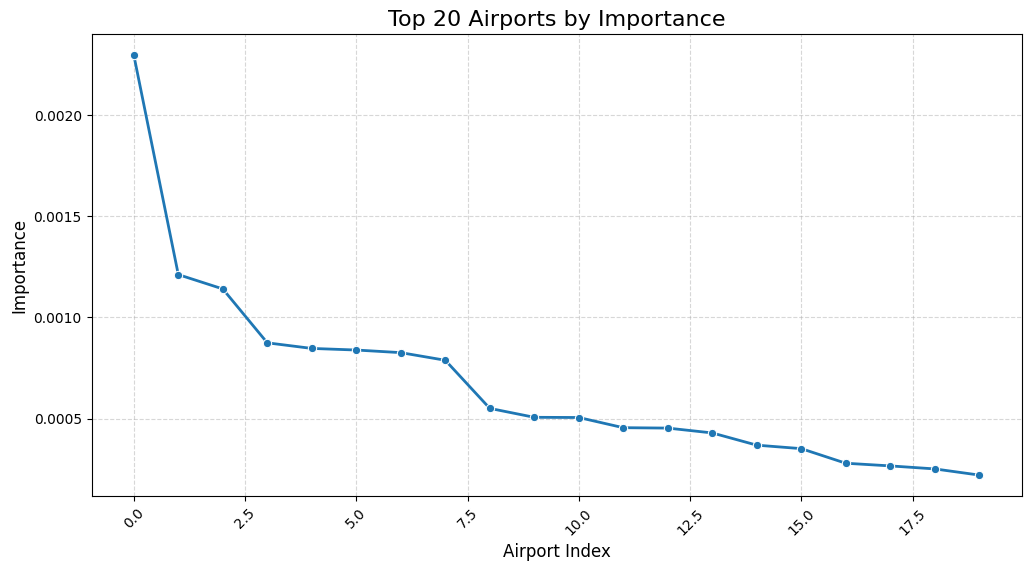

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  
airport_stats.reset_index(drop=True, inplace=True)  #
sns.lineplot(
    data=airport_stats['importance'].head(20),
    marker='o',               
    linewidth=2,              
    markersize=6
)

plt.title('Top 20 Airports by Importance', fontsize=16)
plt.xlabel('Airport Index', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight
